In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
h5py._errors.unsilence_errors()
from mpl_toolkits.axes_grid1 import make_axes_locatable

# SUGGESTION: create all folders for storing results
if not os.path.exists('./vis'):
    os.mkdir('./vis')

if not os.path.exists('./vis_results'):
    os.mkdir('./vis_results')

if not os.path.exists('./model256_weights'):
    os.mkdir('./model256_weights')

# if not os.path.exists('./tb_logs'):
#     os.mkdir('./tb_logs')

if not os.path.exists('./lightning_logs'):
    os.mkdir('./lightning_logs')

In [16]:
#import other module

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import sys
sys.path.append('/kaggle/input/helpfunction3/')




/kaggle/input/helpfunction3/dataset.py
/kaggle/input/helpfunction3/pre_processing.py
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_3.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_3.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_3.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_0_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_1.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_1_0.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_3_2.hdf5
/kaggle/input/track2dataset/256modelruns/Pe1_K1_2_3.hdf5


In [17]:
!pip install -U segmentation_models_pytorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install lightning
!pip install tensorboard


Looking in indexes: https://download.pytorch.org/whl/cu121


    Import Lightning: Import the necessary modules from PyTorch Lightning

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split


import lightning as L

import albumentations as albu

import segmentation_models_pytorch as smp
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

import torch.nn.functional as F
import pandas as pd

from itertools import product
import h5py


from torch.utils.data import RandomSampler

    Define LightningModule: Create a LightningModule class that inherits from pl.LightningModule. This class will contain your model architecture and training logic.



In [19]:
class MyLightningModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = smp.Unet(
            encoder_name='resnet34',
            encoder_weights=None,
            in_channels=4,
            classes=1,
            activation='sigmoid'
        )
        self.l2_loss = torch.nn.MSELoss()
        self.l1_loss = torch.nn.L1Loss()
        
        #save all hyperparameters
        self.save_hyperparameters()
        
        self.record_trainloss=[]
        self.record_valoss=[]
        self.record_testloss=[]
        
        self.validation_step_outputs = []
        self.training_step_outputs = []
    
    #When using forward, you are responsible to call eval() and use the no_grad() context manager.
    def forward(self, x):
        
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self.model(imgs).squeeze()
        loss = self.l1_loss(preds, masks)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #self.logger.experiment.add_scalar('train_loss',loss, self.current_epoch)
        
        self.training_step_outputs.append(loss)

        
        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self.model(imgs).squeeze()
        val_loss = self.l1_loss(preds, masks)
        
        self.log('val_loss', val_loss, prog_bar=True)
        #self.logger.experiment.add_scalar('val_loss',val_loss, self.current_epoch)
        
        self.validation_step_outputs.append(val_loss)
        
        return val_loss
    
    def test_step(self, batch, batch_idx):
        
        imgs, masks = batch
        preds = self.model(imgs).squeeze()
        test_loss = self.l1_loss(preds, masks)
        
        self.log("test_loss", test_loss, prog_bar=True)
        
#         metrics = {"test_loss": test_loss}
#         self.log_dict(metrics)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam([ dict(params=self.model.parameters(), lr=5e-4),])
        
        return optimizer

    def on_train_epoch_end(self):
        avg_train_loss = torch.stack(self.training_step_outputs).mean()
        
        self.record_trainloss.append(avg_train_loss)
        
        self.training_step_outputs=[]
        #self.log('all_train_losses', all_train_loss)

    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        
        
        self.record_valoss.append(avg_val_loss)
        
        self.validation_step_outputs=[]
        



    Define LightningDataModule: If you're using custom data loaders, create a LightningDataModule class that inherits from pl.LightningDataModule. This class will contain your data loading logic.

In [20]:

from dataset import MyDataset

    
class MyDataModule(L.LightningDataModule):
    def __init__(self, augmentation=None, preprocessing=None, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.n_training_samples = 10
        self.n_valid_samples = 2
        self.n_test_samples = 4

        
    def setup(self, stage=None):

        #get the file names
        permutations = list(product(range(4), repeat=2))
        file_list = []
        properties_list = []
        for idx1, idx2 in permutations:
            file_name = f'/kaggle/input/track2dataset/256modelruns/Pe1_K1_{idx1}_{idx2}.hdf5'
            file_list.append(file_name)


        # # set breakpoint
        # import pdb
        #pdb.set_trace()
        self.example_dataset = MyDataset(file_list[:3],self.augmentation[0], self.preprocessing)
        
        self.train_dataset = MyDataset(file_list[:self.n_training_samples],self.augmentation[0], self.preprocessing)
        
        self.val_dataset = MyDataset(file_list[self.n_training_samples : self.n_training_samples+self.n_valid_samples],self.augmentation[1], self.preprocessing)
        
        self.test_dataset = MyDataset(file_list[-self.n_test_samples :], self.augmentation[2], self.preprocessing)
     
             
    def train_dataloader(self):
        train_sampler = RandomSampler(self.train_dataset, replacement=True, num_samples=10000) 
        return DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=train_sampler, num_workers=4, drop_last=True, persistent_workers=True) # 

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False, drop_last=True, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4,persistent_workers=True)


    Training Loop with Trainer: Create a pl.Trainer object and use it to train your LightningModule.

* from commandline, type tensorboard --logdir=lightning_logs/



In [21]:
def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 256),  # not needed
        # albu.HorizontalFlip(p=0.5),
        # albu.VerticalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Resize to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 256),  
    ]
    return albu.Compose(test_transform)

In [22]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.profilers import AdvancedProfiler

from pre_processing import get_preprocessing

from lightning.pytorch.loggers import TensorBoardLogger


augumentations=[get_training_augmentation(), get_validation_augmentation(), get_validation_augmentation()]
# if __name__ == "__main__":

model = MyLightningModel()

data_module = MyDataModule(augmentation=augumentations, preprocessing=get_preprocessing())


# profiler = AdvancedProfiler(dirpath=".", filename="lightning_logs/perf_logs")
#profiler=profiler, default_root_dir='/Users/captainjack/Desktop/CO2_Storage_Jack/'
#consider trying mix precision https://lightning.ai/docs/pytorch/stable/common/precision_intermediate.html
#fast_dev_run=True,
#ModelSummary(max_depth=-1), no need for baseline model
#profiler="simple"

# logger = TensorBoardLogger("tb_logs", name="my_model")

from lightning.pytorch.callbacks import ModelCheckpoint

#save per epoch!
checkpoint_callback = ModelCheckpoint(
    dirpath='/kaggle/working/',
    filename='model-{epoch:04d}',
    save_top_k=1,  # Save all checkpoints
    monitor=None,  # Disable monitoring
    verbose=True
)

trainer = L.Trainer(max_epochs=12,default_root_dir='/kaggle/working/',\
                     callbacks=[checkpoint_callback,TQDMProgressBar(refresh_rate=20),\
                                EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5, \
                                              verbose=False)])
#VisualizationCallback(data_module)

# check validation before large training step
#num_sanity_val_steps=2, 

trainer.fit(model, data_module)

train_loss=model.record_trainloss
val_loss=model.record_valoss


trainer.save_checkpoint("/kaggle/working/example.ckpt")


# test the model 
trainer.test(model, data_module) 


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type    | Params
------------------------------------
0 | model   | Unet    | 24.4 M
1 | l2_loss | MSELoss | 0     
2 | l1_loss | L1Loss  | 0     
------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.758    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=8` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

MisconfigurationException: You called `self.log(test_loss, ...)` twice in `test_step` with different arguments. This is not allowed

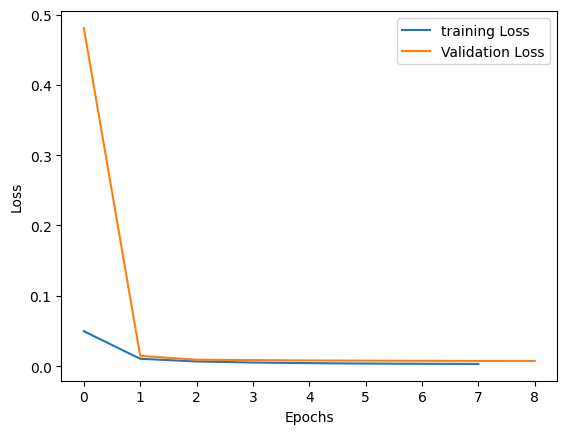

In [23]:
train_losscpu=[t.cpu().detach().numpy() for t in train_loss]
val_losscpu=[t.cpu().detach().numpy() for t in val_loss]

plt.figure()
plt.plot(train_losscpu, label="training Loss")
plt.plot(val_losscpu, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



View logs in tensorboard

If you’re using a notebook environment such as colab or kaggle or jupyter, launch Tensorboard with this command

%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [ ]:
# !kill 400      
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/


Some Plots

In [ ]:

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

for idx_ in range(4):
    current_timestep = 10*idx_
    print(f'plotting for time step: {current_timestep}')
    image, mask = data_module.example_dataset[current_timestep] # get some sample
    visualize(
        concentration=image[0,:, :].squeeze(),
        eps=image[1,:, :].squeeze(),
        Ux=image[2,:, :].squeeze(),
        Uy=image[3,:, :].squeeze(),
        dissolution=mask.squeeze(),
    )

Use original code to do plotting (see test results!)

In [ ]:
def read_simulation_hdf(file_name):
    print(f'loading the file: {file_name}')
    data_dict = {}

    with h5py.File(file_name, "r") as file_handle:
        # List all groups
        print(f"Keys: {file_handle.keys()}")
        scaling_factor = 1
        for key_ in file_handle.keys():
            if 'key_' == 'C':
                scaling_factor = 1 # 100
            elif 'key_' == 'Ux' or 'key_' == 'Uy':
                scaling_factor = 1 # 1000
            
            data_dict[key_] = scaling_factor * np.array(file_handle[key_])
            print(f'Done loading the variable {key_} of shape: {data_dict[key_].shape}')

        print(f'Done with {file_name} == closing file now')

    return data_dict['C'], data_dict['eps'], data_dict['Ux'], data_dict['Uy'],


def load_datafiles(data_filenames):
    # snapshot_indices will split the data in time into train and validation
    data_dict = {
        'C': [], # list of np arrays
        'eps': [],
        'Ux': [],
        'Uy': [],
    }

    for filename in data_filenames:
        C, eps, Ux, Uy = read_simulation_hdf(filename)
        data_dict['C'].append(C[2:-2, 2:-2, :])
        data_dict['eps'].append(eps[2:-2, 2:-2, :])
        data_dict['Ux'].append(Ux[2:-2, 2:-2, :])
        data_dict['Uy'].append(Uy[2:-2, 2:-2, :])
    return data_dict

def get_filelist():
    from itertools import permutations, product
    # permutations = list(permutations(range(4), 2))
    permutations = list(product(range(4), repeat=2))

    file_list = []
    properties_list = []
    for idx1, idx2 in permutations:
        # filename_hdf = f'Pe{peclet_value}_K{k_value}_101steps.hdf5'
        # filename_hdf = f'data_new/Pe{peclet_value[data_idx]}_K{k_value[data_idx]}.hdf5'
        file_name = f'/kaggle/input/track2dataset/256modelruns/Pe1_K1_{idx1}_{idx2}.hdf5'
        file_list.append(file_name)
    return file_list

In [ ]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

def preprocess_data_cube(data_dict, scaling_dict):
    print(f'preprocess_data_cube')

    masks = []
    images = []
    for file_idx in range(len(data_dict['C'])):
        C = data_dict['C'][file_idx][:, :, :-1]
        eps = data_dict['eps'][file_idx][:, :, :-1]
        Ux = data_dict['Ux'][file_idx][:, :, :-1]
        Uy = data_dict['Uy'][file_idx][:, :, :-1]
        eps_t = data_dict['eps'][file_idx][:, :, 1:]

        # mask = log_transform(eps_t - eps[:, :, :-1]) # this scaled from 0 to 1

        #model baseline
        #mask = eps_t - eps

        #model II: predict next snapshot directly!
        mask = eps_t

        #Model III
#         mask = np.stack([C_t, eps_t, Ux_t, Uy_t], axis=-1)
#         mask = np.swapaxes(mask, 3, 2)

        
        
        # these should be moved to preprocessing
        # C_scaled = log_transform(C*scaling_dict['C_scaling']) - 0.5 # scale to be from 0 to 1
        C = C*scaling_dict['C_scaling'] - 0.5
        Ux = (Ux - scaling_dict['Ux_mean']) / scaling_dict['Ux_std']
        Uy = (Uy - scaling_dict['Uy_mean']) / scaling_dict['Uy_std']
        eps = (eps - scaling_dict['eps_mean']) / scaling_dict['eps_std']


        image = np.stack([C, eps, Ux, Uy], axis=-1)
        image = np.swapaxes(image, 3, 2)

        masks.append(mask)
        images.append(image)
    
    masks = np.concatenate(masks, axis=-1)
    images = np.concatenate(images, axis=-1)
    print(f'preprocess_data_cube: {masks.shape}, {images.shape}')
    return images, masks

class DissolutionDataset(Dataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        data_dir (str): path to data folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
  
    def __init__(
            self,
            data_filenames,
            scaling_dict,
            augmentation=None, 
            preprocessing=None,
    ):

        # self.scaling_dict = scaling_dict
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        data_dict = load_datafiles(data_filenames)
        self.image, self.mask = preprocess_data_cube(data_dict, scaling_dict)
        print(self.image.shape, self.mask.shape)
        self.data_len = self.image.shape[-1]

    
    def __getitem__(self, idx):
        
        image = self.image[:, :, :, idx]
        mask = self.mask[:, :, idx]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # assume one file for now
        return self.data_len # last element we cann't predict


In [ ]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 256),  # not needed
        # albu.HorizontalFlip(p=0.5),
        # albu.VerticalFlip(p=0.5),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Resize to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 256),  
    ]
    return albu.Compose(test_transform)


def to_tensor_img(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def to_tensor_mask(x, **kwargs):
    return x.astype('float32')

def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor_img, mask=to_tensor_mask),
    ]
    return albu.Compose(_transform)

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
from torch.utils.data import RandomSampler

In [ ]:
file_list = get_filelist()
print(file_list)

data_list = load_datafiles(file_list)
# estimate sample mean and std -- this should be done better

n_training_samples = 8


C = np.stack([data_list['C'][idx] for idx in range(n_training_samples)])
eps = np.stack([data_list['eps'][idx] for idx in range(n_training_samples)])
Ux = np.stack([data_list['Ux'][idx] for idx in range(n_training_samples)])
Uy = np.stack([data_list['Uy'][idx] for idx in range(n_training_samples)])

Ux_mean, Ux_std = Ux.mean(), Ux.std()
Uy_mean, Uy_std = Uy.mean(), Uy.std()
eps_mean, eps_std = eps.mean(), eps.std()


print(Ux_mean, Ux_std)
print(Uy_mean, Uy_std)
print(eps_mean, eps_std)

C_scaling = 100
data_scalingdict = {
    'C_scaling': C_scaling,
    'Ux_mean': Ux_mean,
    'Ux_std': Ux_std,
    'Uy_mean': Uy_mean,
    'Uy_std': Uy_std,
    'eps_mean': eps_mean,
    'eps_std': eps_std,
}

del Ux, Uy, eps, C

In [ ]:
from datetime import datetime

data_filenames = get_filelist()

dataset_train = DissolutionDataset(
    data_filenames[:8],
    scaling_dict=data_scalingdict,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
)

dataset_valid = DissolutionDataset(
    data_filenames[12:],
    scaling_dict=data_scalingdict,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

del data_scalingdict

In [ ]:
# train_sampler = RandomSampler(dataset_train, replacement=False, num_samples=None)
train_sampler = RandomSampler(dataset_train, replacement=True, num_samples=10000)
train_loader = DataLoader(dataset_train, batch_size=64, num_workers=4, sampler=train_sampler, drop_last=True)                        
valid_loader = DataLoader(dataset_valid, batch_size=4, num_workers=4, shuffle=False, drop_last=True)

del dataset_train, dataset_valid


In [ ]:
model = MyLightningModel.load_from_checkpoint('/kaggle/working/example.ckpt')
model.eval()

cpu_device = torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

l2_loss = torch.nn.MSELoss() # smp.losses.DiceLoss()
l1_loss = torch.nn.L1Loss() # solution is sparse

with torch.no_grad():
    # loop 1 on training data
    train_loss = []
    # train_loss_scaled = []
    preds_list_train = []
    masks_list_train = []

    for imgs, masks in tqdm(train_loader):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True) # .squeeze()
        preds = model(imgs).squeeze()

        l2_loss_values = l2_loss(masks, preds)
        train_loss.append(l2_loss_values.item())

        # store the true values
        # Changed to store in CPU
        masks_list_train.append(masks.to(cpu_device).numpy())
        preds_list_train.append(preds.to(cpu_device).numpy())

    train_loss = np.array(train_loss)
    print(f'train_loss: {train_loss.mean()}')
    
    val_loss = []
    preds_list_val = []
    masks_list_val = []

    # loop 2 on validation data
    for imgs, masks in tqdm(valid_loader):
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)# .squeeze()
        preds = model(imgs).squeeze()

        l2_loss_values = l2_loss(masks, preds)
        val_loss.append(l2_loss_values.item())

        # store the true values
        # Changed to store in CPU
        masks_list_val.append(masks.to(cpu_device).numpy())
        preds_list_val.append(preds.to(cpu_device).numpy())

    val_loss = np.array(val_loss)
    print(f'validation_loss: {val_loss.mean()}') #, val_loss_scaled: {val_loss_scaled.mean()}')

In [ ]:
preds_list_train = np.concatenate(preds_list_train)
masks_list_train = np.concatenate(masks_list_train)

preds_list_val = np.concatenate(preds_list_val)
masks_list_val = np.concatenate(masks_list_val)

In [ ]:
def matshow_error(pred, truth, figsize=(40, 18), scale=False, title=None, filename=None):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    
    v_max = max(truth.max(), pred.max())
    v_min = max(truth.min(), pred.min())

    if scale:
        im = ax[0].matshow(pred, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[0].matshow(pred, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    # im.set_clim(0.0, 0.3)
    ax[0].set_title(f'{title} prediction')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)

    if scale:
        im = ax[1].matshow(truth, vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    else:
        im = ax[1].matshow(truth, vmin=v_min, vmax=v_max, cmap=plt.get_cmap('Reds'))# 'inferno_r'))
    # im.set_clim(0.0, 0.3)
    ax[1].set_title(f'{title} reference')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # error = np.abs(pred-truth)
    error = pred-truth

    im = ax[2].matshow(error, cmap=plt.get_cmap('seismic')) #.get_cmap('RdGy'))
    max_abs_error = np.max(np.abs(error))
    # Set the color limits dynamically centered around zero
    clim = (-max_abs_error, max_abs_error)
    im.set_clim(clim)

    ax[2].set_title(f'{title} error')
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

for sample_idx in range(1): #12):
    for time_step in [0, 1, 3, 7, 10, 20, 40, 60, 90, 99]:
        preds = preds_list_train[sample_idx*100+time_step, :, :]
        masks = masks_list_train[sample_idx*100+time_step, :, :]
        # matshow2(scaling_func(preds), scaling_func(masks), title=f'train sample: {sample_idx}, scaled prediction eps', filename='original_eps.pdf')
        matshow_error(
            preds,
            masks, 
            title=f'train sample: {sample_idx}, timestep: {time_step}, eps: ', 
            filename=f'vis_results/training_eps_{sample_idx}_{time_step}.pdf',
            figsize=(15, 7))

        
for sample_idx in range(1): #4):
    for time_step in [0, 1, 3, 7, 10, 20, 40, 60, 90, 99]:
        preds = preds_list_val[sample_idx*100+time_step, :, :]
        masks = masks_list_val[sample_idx*100+time_step, :, :]
        # matshow2(scaling_func(preds), scaling_func(masks), title=f'validation sample: {sample_idx}, scaled prediction eps', filename='original_eps.pdf')
        matshow_error(
            preds,
            masks,
            title=f'validation sample: {sample_idx}, timestep: {time_step}, eps: ', 
            filename=f'vis_results/validation_eps_{sample_idx}_{time_step}.pdf',
            figsize=(15, 7))


In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/working/tb_logs'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))